In [1]:
%reload_kedro

2023-08-03 13:33:28,580 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-08-03 13:33:29,425 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-08-03 13:33:29,625 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-08-03 13:33:29,626 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2023-08-03 13:33:29,639 - kedro.extras.extensions.ipython - INFO - Registered line magic `run_viz`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
import math
import seaborn as sns

In [4]:
portfolio_initial_money = catalog.load("params:portfolio_initial_money")

2023-08-03 13:33:30,368 - kedro.io.data_catalog - INFO - Loading data from `params:portfolio_initial_money` (MemoryDataSet)...


## Buy and Hold

In [5]:
df_benchm_buyhold = catalog.load("benchmark_buyhold_strat")

2023-08-03 13:33:30,393 - kedro.io.data_catalog - INFO - Loading data from `benchmark_buyhold_strat` (ParquetDataSet)...


In [6]:
first_time = df_benchm_buyhold.date.min()
last_time = df_benchm_buyhold.date.max()

first_price = float(df_benchm_buyhold[df_benchm_buyhold["date"] == first_time]["close_px"])
last_price = float(df_benchm_buyhold[df_benchm_buyhold["date"] == last_time]["close_px"])

In [7]:
# retorno percentual
pctchg = last_price / first_price - 1

# profit nominal
qty = math.floor(portfolio_initial_money / first_price)
profit_nominal = qty * last_price - portfolio_initial_money

# sharpe
vol = np.nanstd(df_benchm_buyhold["pctchg"], ddof=1)
sharpe = pctchg / vol

In [8]:
print(f"Cumulative return: {pctchg*100}%")
print(f"Nominal profit: {profit_nominal}")
print(f"Sharpe: {sharpe}")

Cumulative return: 208.60814237114064%
Nominal profit: 311549.4
Sharpe: 506.27275375812945


## Trend Following

### Operations Profit over Time

In [9]:
df_portf_pnl = catalog.load("benchmark_trendfollowing_pnl")

2023-08-03 13:33:30,554 - kedro.io.data_catalog - INFO - Loading data from `benchmark_trendfollowing_pnl` (ParquetDataSet)...


In [10]:
df_ops = df_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

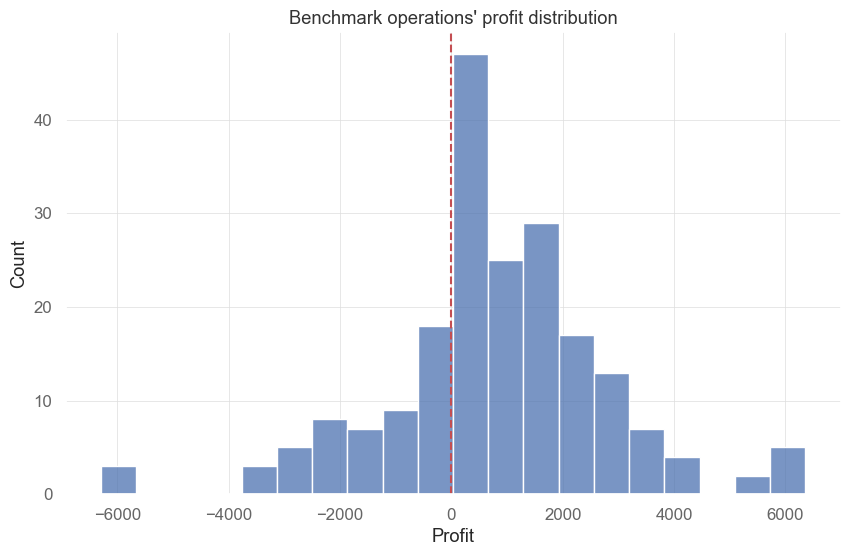

In [11]:
df = df_ops[["close_time", "op_full_profit"]] \
            .rename(columns={"close_time": "Date",
                            "op_full_profit": "Profit"}) \
            .set_index("Date") \
            .sort_index()

plot = sns.histplot(data=df,
             legend=None,
             x="Profit",
            ) \
            .set(title="Benchmark operations' profit distribution")

plt.axvline(x=0, color="r", ls="--")

plt.savefig("/Users/gpalazzo/Desktop/fig_benchm_tf_ops_profit.png")

<Axes: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

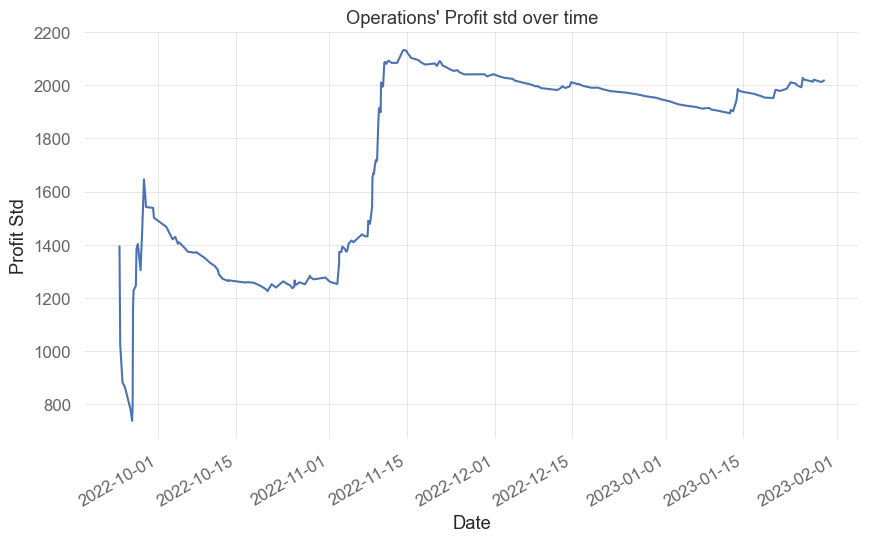

In [12]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<Axes: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

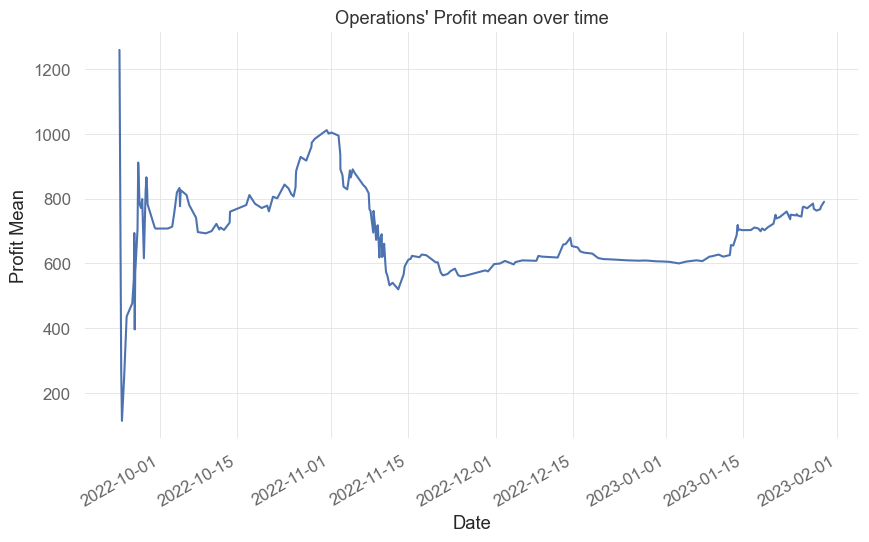

In [13]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

### Portfolio overall metrics - Part 1

In [14]:
df_portf_metr = catalog.load("benchmark_trendfollowing_metrics")
df_portf_metr.loc[:, "model"] = "benchmark_tf"
df_portf_metr

2023-08-03 13:33:32,693 - kedro.io.data_catalog - INFO - Loading data from `benchmark_trendfollowing_metrics` (ParquetDataSet)...


,nominal_profit,consecutive_wins,consecutive_losses,model
0,159591.823056,16,4,benchmark_tf


### Portfolio overall metrics - Part 2

In [15]:
df_portf_pnl = catalog.load("benchmark_trendfollowing_pnl")

df_portf_pnl.loc[:, "logret_pos"] = np.log(1 + df_portf_pnl["pctchg_pos"])

df_logret = df_portf_pnl[["close_time", "pctchg_pos", "logret_pos"]] \
                        .rename(columns={"close_time": "date"}) \
                        .set_index("date").sort_index()

df_logret.loc[:, "logret_accum"] = df_logret["logret_pos"].cumsum()
df_logret.loc[:, "pctchg_accum"] = np.exp(df_logret["logret_accum"]) - 1

df_logret = df_logret[["pctchg_pos", "pctchg_accum"]] \
                    .rename(columns={"pctchg_pos": "portf_pctchg_pos",
                                   "pctchg_accum": "portf_pctchg_accum"})

df_logret.index = pd.to_datetime(df_logret.index)

2023-08-03 13:33:32,739 - kedro.io.data_catalog - INFO - Loading data from `benchmark_trendfollowing_pnl` (ParquetDataSet)...


In [16]:
qs.reports.metrics(returns=df_logret["portf_pctchg_pos"], periods_per_year=360, mode="full")

                           Strategy
-------------------------  ----------
Start Period               2022-09-23
End Period                 2023-01-29
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          106.4%
CAGR﹪                     689.56%

Sharpe                     7.52
Prob. Sharpe Ratio         100.0%
Smart Sharpe               7.27
Sortino                    13.51
Smart Sortino              13.06
Sortino/√2                 9.55
Smart Sortino/√2           9.23
Omega                      2.9

Max Drawdown               -6.04%
Longest DD Days            22
Volatility (ann.)          17.4%
Calmar                     114.24
Skew                       -0.35
Kurtosis                   1.65

Expected Daily %           0.36%
Expected Monthly %         15.6%
Expected Yearly %          43.66%
Kelly Criterion            48.35%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.14%
Expected Shortfall (cVaR)  -1.14%

Max Consecutive Wins  